Carga del dataset Fashion-MNIST

In [ ]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Paquetes para construir la red neuronal

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

Codigo para visualizar las imagenes del dataset

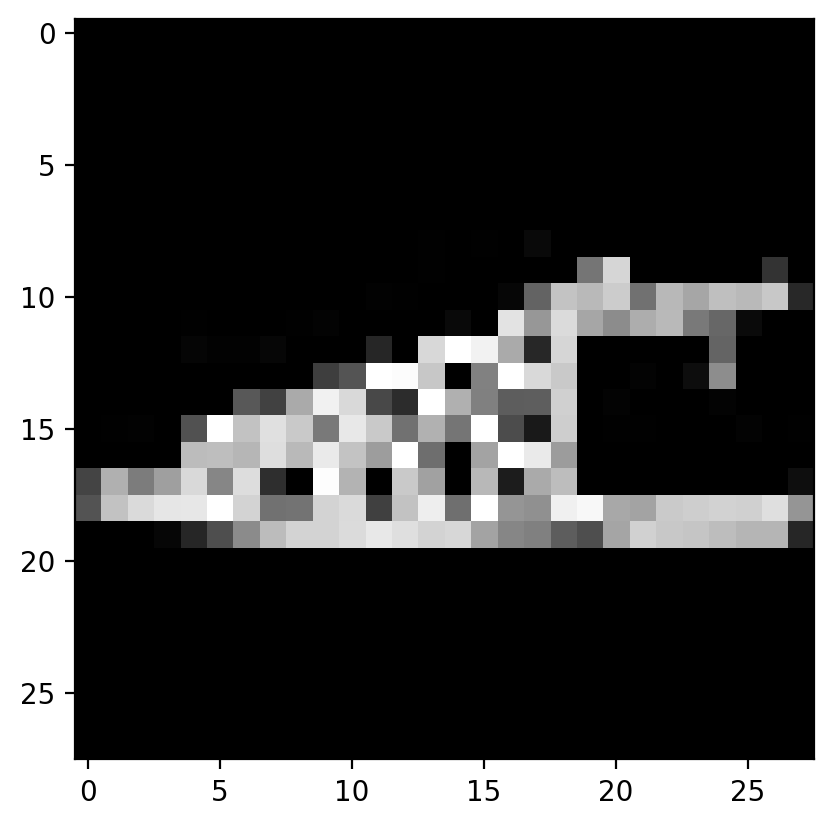

In [ ]:
def imshow(img):
    # Unnormalize the image (reverse the (0.5,) normalization)
    img = img / 2 + 0.5
    npimg = img.numpy()

    # Fashion-MNIST images are 1 channel (grayscale)
    # Squeeze the channel dimension if present (e.g., from (1, 28, 28) to (28, 28))
    if npimg.ndim == 3 and npimg.shape[0] == 1:
        npimg = npimg.squeeze(0)

    plt.imshow(npimg, cmap='gray') # Use 'gray' colormap for grayscale images
    plt.show()

image, label = next(iter(trainloader))
imshow(image[0,:]);

Red neuronal

Definicion de la arquitectura

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # DEFINICIÓN DE CAPAS
        # Capa de entrada a Capa Oculta 1, entrada: 784 (28x28 píxeles aplanados), Salida: 256
        self.fc1 = nn.Linear(784, 256)

        # Capa Oculta 1 a Capa Oculta 2
        self.fc2 = nn.Linear(256, 128)

        # Capa Oculta 2 a Capa de Salida
        # Salida: 10 (porque hay 10 clases en Fashion-MNIST)
        self.fc3 = nn.Linear(128, 10)

        # Dropout para evitar sobreajuste (overfitting)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # FLUJO DE DATOS(FORWARD PASS)

        # Paso 0: Aplanar la imagen (Flatten), Convertimos el tensor de [Batch, 1, 28, 28] a [Batch, 784]
        x = x.view(x.shape[0], -1)

        # Paso 1: Capa 1 + Activación ReLU + Dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # Paso 2: Capa 2 + Activación ReLU + Dropout
        x = self.dropout(F.relu(self.fc2(x)))

        # Paso 3: Capa de Salida
        # La función de pérdida (CrossEntropyLoss) aplicará Softmax internamente.
        x = self.fc3(x)

        return x

In [ ]:
# Instacia de la red
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Entrenamiento de la red

In [ ]:
# 1. Definir el criterio (Función de pérdida)
# Usamos CrossEntropyLoss porque es estándar para clasificación multiclase.
# Esta función espera LOGITS crudos como entrada, no probabilidades.
criterion = nn.CrossEntropyLoss()

# 2. Definir el optimizador
# Usamos Adam con un learning rate de 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

# 3. Entrenar la red
epochs = 10

print("Iniciando entrenamiento...")

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        # A. Limpiar gradientes poruqe pytorch acumula gradientes por defecto
        optimizer.zero_grad()

        # B. Forward pass (Obtener logits)
        output = model(images)

        # C. Calcular la pérdida (Loss)
        loss = criterion(output, labels)

        # D. Backward pass (Calcular gradientes usando Backpropagation)
        loss.backward()

        # E. Actualizar pesos (Optimizer step)
        optimizer.step()

        running_loss += loss.item()
    else:
        # Imprimir métricas al final de cada época
        print(f"Training loss: {running_loss/len(trainloader)}")

Iniciando entrenamiento...
Training loss: 0.5570698433529848
Training loss: 0.4546011171774315
Training loss: 0.4335713897750322
Training loss: 0.41056741726423884
Training loss: 0.4007420630645015
Training loss: 0.3930971256927895
Training loss: 0.38220909770840267
Training loss: 0.3741785174430306
Training loss: 0.37058212536611534
Training loss: 0.36074552669136256


Prediccion y probabilidades

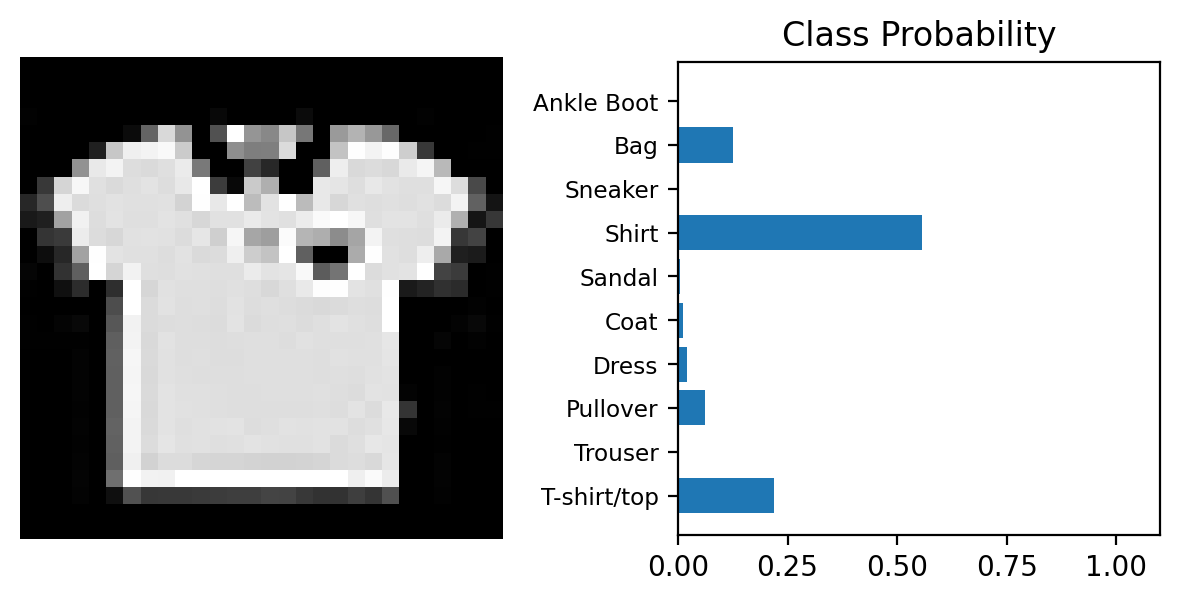

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version=""):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

# Test
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convertir imagen 2D a vector 1D
img = img.resize_(1, 784)

# Calcular la clase probabilidades (softmax) para img
# Como el modelo devuelve logits, aplicamos softmax en la dimensión 1 (las clases)
with torch.no_grad(): # Desactivamos el rastreo de gradientes para hacerlo mas rapido
    logits = model(img)
    ps = F.softmax(logits, dim=1)

# Plot de imagenes y probabilidades
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')